In [2]:
import azureml.core
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Experiment, Workspace

# Check core SDK version number
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")
print("")

# Log In to Azure ML Workspace
interactive_auth = InteractiveLoginAuthentication(tenant_id="76f90eb1-fb9a-4446-9875-4d323d6455ad")

ws = Workspace.from_config(auth=interactive_auth)
print('Workspace name: ' + ws.name, sep='\n')

You are currently using version 1.8.0 of the Azure ML SDK

Workspace name: team20


In [3]:
from azureml.core import Dataset
aml_dataset = Dataset.get_by_name(ws, 'train_ds', version='latest')
data = aml_dataset.to_pandas_dataframe()

/anaconda/envs/py37_default/lib/python3.7/site-packages/azureml/dataprep/api/dataflow.py:722: UserWarning: Your pandas and pyarrow versions are incompatible. Please install pyarrow>=0.12.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install pyarrow>=0.12.0 --upgrade
  warnings.warn('Your pandas and pyarrow versions are incompatible. '


In [5]:
data = data_backup.copy()

In [59]:
import modin.pandas as pd
import numpy as np

data.set_index('CardHolder', drop=True, inplace=True)
data['group'].replace({'test': 1, 'control': 0}, inplace=True)
data['gender'].replace({'Ж': 0, 'М': 1, 'Не определен': np.NaN}, inplace=True)

In [14]:
import xgboost
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, stratify=data['response_att'],
                                   shuffle=True)


In [17]:
params = {'n_estimators': 20, 'eval_metric': ['logloss', 'auc', 'error'], 'verbose': True, 'n_jobs': -1}
model = xgboost.XGBClassifier(**params)

X_train = train.drop('response_att', axis=1)
y_train = train['response_att']

X_test = test.drop('response_att', axis=1)
y_test = test['response_att']

In [18]:
model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.630031	validation_0-auc:0.766055	validation_0-error:0.105963
[1]	validation_0-logloss:0.578451	validation_0-auc:0.774827	validation_0-error:0.105869
[2]	validation_0-logloss:0.535591	validation_0-auc:0.775505	validation_0-error:0.105694
[3]	validation_0-logloss:0.499767	validation_0-auc:0.780539	validation_0-error:0.104879
[4]	validation_0-logloss:0.469424	validation_0-auc:0.783665	validation_0-error:0.104843
[5]	validation_0-logloss:0.443672	validation_0-auc:0.784574	validation_0-error:0.10485
[6]	validation_0-logloss:0.42176	validation_0-auc:0.784848	validation_0-error:0.105025
[7]	validation_0-logloss:0.402891	validation_0-auc:0.784957	validation_0-error:0.105003
[8]	validation_0-logloss:0.386719	validation_0-auc:0.785164	validation_0-error:0.104792
[9]	validation_0-logloss:0.372762	validation_0-auc:0.784819	validation_0-error:0.104864
[10]	validation_0-logloss:0.36075	validation_0-auc:0.784801	validation_0-error:0.104886
[11]	validation_0-logloss:0.350381

XGBClassifier(eval_metric=['logloss', 'auc', 'error'], n_estimators=20,
              n_jobs=-1, verbose=True)

In [23]:
def importances(train, model):
    cols = list(train.drop('response_att', axis=1).columns)

    feats = pd.Series(data=model.feature_importances_, index=cols) 
    feats.sort_values(ascending=False, inplace=True)
    print(feats.head(20))

In [24]:
importances(train, model)

k_var_days_between_visits_1m           0.317405
perdelta_days_between_visits_15_30d    0.212026
k_var_days_between_visits_15d          0.152806
stdev_days_between_visits_15d          0.049486
k_var_days_between_visits_3m           0.042280
cheque_count_6m_g40                    0.034235
cheque_count_6m_g32                    0.028553
cheque_count_12m_sum                   0.028277
cheque_count_6m_g41                    0.018373
cheques_per_child                      0.016887
k_var_disc_share_3m_g24                0.016651
cheque_count_12m_g48                   0.013941
food_share_1m                          0.013861
cheque_count_6m_g25                    0.012009
cheque_count_12m_g32                   0.011357
months_from_register                   0.008419
k_var_disc_per_cheque_15d              0.008339
food_share_15d                         0.007714
k_var_sku_price_6m_max                 0.007381
k_var_count_per_cheque_1m_g24          0.000000
dtype: float32


In [29]:
pred = model.predict_proba(X_test)

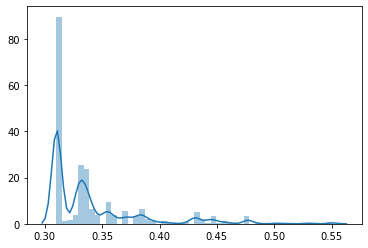

In [31]:
import seaborn as sns
sns.distplot(pred[:,1])

In [36]:
train1 = X_train[y_train == 1]
train0 = X_train[y_train == 0]

In [63]:
cols = list(train.drop('response_att', axis=1).columns)

feats = pd.Series(data=model.feature_importances_, index=cols) 
feats.sort_values(ascending=False, inplace=True)
feats.head(15)

k_var_days_between_visits_15d          0.466894
k_var_days_between_visits_1m           0.211764
perdelta_days_between_visits_15_30d    0.145268
stdev_days_between_visits_15d          0.053817
cheque_count_6m_g40                    0.036728
k_var_days_between_visits_3m           0.032206
cheque_count_12m_g32                   0.016181
cheque_count_6m_g48                    0.015134
cheque_count_12m_g48                   0.014948
k_var_cheque_15d                       0.007059
k_var_sku_price_1m_g49                 0.000000
k_var_sku_price_1m_g54                 0.000000
k_var_sku_price_1m_g44                 0.000000
k_var_sku_price_3m_g24                 0.000000
k_var_sku_price_3m_g26                 0.000000
dtype: float32

In [9]:
import sys
sys.path.append('../features')

In [10]:
from functions import preprocessing

In [69]:
data = data_backup.copy()

In [12]:
import numpy as np
import pandas as pd

In [13]:
data = data_backup.copy()
full_prep(data)

In [6]:
def full_prep(data):
    preprocessing(data)
    data['group'].replace({'test': 1, 'control': 0}, inplace=True)
    data['gender'].replace({'Ж': 0, 'М': 1, 'Не определен': np.NaN}, inplace=True)

In [27]:
data['group']

0         1
1         1
2         0
3         1
4         1
         ..
687024    0
687025    1
687026    0
687027    0
687028    1
Name: group, Length: 687029, dtype: int64

In [28]:
data['class'] = 0
data.loc[(data['group'] == 0) & (data['response_att'] == 1), 'class'] = 1
data.loc[(data['group'] == 1) & (data['response_att'] == 0), 'class'] = 2
data.loc[(data['group'] == 1) & (data['response_att'] == 1), 'class'] = 3

In [40]:
#y = data['class']
#data.drop(['group', 'response_att', 'class'], axis=1, inplace=True)

x_train, x_test, y_train, y_test = train_test_split(data, y)

In [38]:
y_test.shape

(171758,)

In [42]:
params = {'n_estimators': 20, 'eval_metric': ['merror', 'mlogloss'], 'verbose': True, 'n_jobs': -1}
model = xgboost.XGBClassifier(**params)

model.fit(x_train, y_train, verbose=True, eval_set=[(x_test, y_test)])

[0]	validation_0-merror:0.331053	validation_0-mlogloss:1.31556
[1]	validation_0-merror:0.327205	validation_0-mlogloss:1.25633
[2]	validation_0-merror:0.323688	validation_0-mlogloss:1.20557
[3]	validation_0-merror:0.323199	validation_0-mlogloss:1.16216
[4]	validation_0-merror:0.323135	validation_0-mlogloss:1.12503
[5]	validation_0-merror:0.323199	validation_0-mlogloss:1.09279
[6]	validation_0-merror:0.322978	validation_0-mlogloss:1.06471
[7]	validation_0-merror:0.322949	validation_0-mlogloss:1.04022
[8]	validation_0-merror:0.322949	validation_0-mlogloss:1.01869
[9]	validation_0-merror:0.322809	validation_0-mlogloss:0.999763
[10]	validation_0-merror:0.322547	validation_0-mlogloss:0.983014
[11]	validation_0-merror:0.322553	validation_0-mlogloss:0.96819
[12]	validation_0-merror:0.322227	validation_0-mlogloss:0.954936
[13]	validation_0-merror:0.322168	validation_0-mlogloss:0.943311
[14]	validation_0-merror:0.322203	validation_0-mlogloss:0.932988
[15]	validation_0-merror:0.322104	validation_

XGBClassifier(eval_metric=['merror', 'mlogloss'], n_estimators=20, n_jobs=-1,
              objective='multi:softprob', verbose=True)

In [44]:
pred = model.predict_proba(x_test)

In [46]:
final = pred[:,3] + pred[:,0] - pred[:,1] - pred[:,2]

In [51]:
test['group'].replace({1: 'test', 0: 'control'}, inplace=True)
test['uplift'] = final

/anaconda/envs/py37_default/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


ValueError: Length of values does not match length of index

In [73]:
data = data_backup.copy()
data['gender'].replace({'Ж': 0, 'М': 1, 'Не определен': np.NaN}, inplace=True)
data['class'] = 0
data.loc[(data['group'] == 'control') & (data['response_att'] == 1), 'class'] = 1
data.loc[(data['group'] == 'test') & (data['response_att'] == 0), 'class'] = 2
data.loc[(data['group'] == 'test') & (data['response_att'] == 1), 'class'] = 3

train, test = train_test_split(data)

x_train = train.drop(['class', 'group', 'response_att'], axis=1)
y_train = train['class']

x_test = test.drop(['class', 'group', 'response_att'], axis=1)
y_test = test['class']

params = {'n_estimators': 20, 'eval_metric': ['merror', 'mlogloss'], 'verbose': True, 'n_jobs': -1}
model = xgboost.XGBClassifier(**params)

model.fit(x_train, y_train, verbose=True, eval_set=[(x_test, y_test)])

[0]	validation_0-merror:0.326727	validation_0-mlogloss:1.31535
[1]	validation_0-merror:0.326913	validation_0-mlogloss:1.25594
[2]	validation_0-merror:0.326162	validation_0-mlogloss:1.20541
[3]	validation_0-merror:0.32455	validation_0-mlogloss:1.1621
[4]	validation_0-merror:0.324451	validation_0-mlogloss:1.12474
[5]	validation_0-merror:0.323938	validation_0-mlogloss:1.09224
[6]	validation_0-merror:0.323921	validation_0-mlogloss:1.06397
[7]	validation_0-merror:0.323886	validation_0-mlogloss:1.0392
[8]	validation_0-merror:0.32388	validation_0-mlogloss:1.01747
[9]	validation_0-merror:0.324101	validation_0-mlogloss:0.9983
[10]	validation_0-merror:0.32388	validation_0-mlogloss:0.981383
[11]	validation_0-merror:0.323717	validation_0-mlogloss:0.966411
[12]	validation_0-merror:0.323641	validation_0-mlogloss:0.953149
[13]	validation_0-merror:0.322692	validation_0-mlogloss:0.941169
[14]	validation_0-merror:0.322436	validation_0-mlogloss:0.930655
[15]	validation_0-merror:0.32243	validation_0-mlogl

XGBClassifier(eval_metric=['merror', 'mlogloss'], n_estimators=20, n_jobs=-1,
              objective='multi:softprob', verbose=True)

In [74]:
pred = model.predict_proba(x_test)
final = pred[:,3] + pred[:,0] - pred[:,1] - pred[:,2]
test['uplift'] = final

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
import sys
sys.path.append('../scripts')
from metrics import custom_metric

In [76]:
custom_metric(test)

6.59637795600698

In [71]:
def importances(train, model):
    cols = list(train.columns)

    feats = pd.Series(data=model.feature_importances_, index=cols) 
    feats.sort_values(ascending=False, inplace=True)
    print(feats.head(25))

In [77]:
importances(x_train, model)

k_var_days_between_visits_1m           0.194580
response_viber                         0.129193
k_var_days_between_visits_15d          0.098927
perdelta_days_between_visits_15_30d    0.064977
sale_count_12m_g49                     0.048989
k_var_disc_share_6m_g49                0.047806
response_sms                           0.041839
k_var_days_between_visits_3m           0.031701
cheque_count_6m_g32                    0.026364
k_var_sku_price_6m_g27                 0.022708
cheque_count_12m_g41                   0.020543
k_var_sku_price_6m_g24                 0.020302
cheque_count_6m_g40                    0.019642
k_var_sku_price_3m_g24                 0.018569
cheque_count_12m_g48                   0.018418
sale_sum_12m_g27                       0.017854
stdev_days_between_visits_15d          0.017021
cheque_count_6m_g48                    0.014931
cheque_count_6m_g41                    0.013503
cheque_count_12m_g38                   0.012303
cheque_count_12m_g25                   0

In [78]:
from pipeline import IndianModel

Perhaps you already have a cluster running?
Hosting the HTTP server on port 41089 instead


In [13]:
import sys
sys.path.append('../scripts')
import numpy as np
import modin.pandas as pd

from importlib import reload
import pipeline
reload(pipeline)
from pipeline import validate_on_holdout, IndianModel, StackedModel
pd.options.mode.chained_assignment = None

In [5]:
data['gender'].replace({'Ж': 0, 'М': 1, 'Не определен': np.NaN}, inplace=True)
data_backup = data.copy()

In [95]:
params = {'n_estimators': 30, 'eval_metric': ['merror', 'mlogloss'], 'verbose': True, 'n_jobs': -1}
model = IndianModel(params)

data = data_backup.copy()
data['gender'].replace({'Ж': 0, 'М': 1, 'Не определен': np.NaN}, inplace=True)

scores, model = validate_on_holdout(data, model, verbose=False)
scores

[0]	validation_0-merror:0.328355	validation_0-mlogloss:1.3155
[1]	validation_0-merror:0.328392	validation_0-mlogloss:1.25621
[2]	validation_0-merror:0.328348	validation_0-mlogloss:1.20586
[3]	validation_0-merror:0.32273	validation_0-mlogloss:1.16226
[4]	validation_0-merror:0.323603	validation_0-mlogloss:1.12503
[5]	validation_0-merror:0.322599	validation_0-mlogloss:1.09274
[6]	validation_0-merror:0.322693	validation_0-mlogloss:1.06458
[7]	validation_0-merror:0.322562	validation_0-mlogloss:1.03998
[8]	validation_0-merror:0.323392	validation_0-mlogloss:1.01841
[9]	validation_0-merror:0.323283	validation_0-mlogloss:0.999397
[10]	validation_0-merror:0.323086	validation_0-mlogloss:0.982623
[11]	validation_0-merror:0.322977	validation_0-mlogloss:0.967787
[12]	validation_0-merror:0.322206	validation_0-mlogloss:0.954443
[13]	validation_0-merror:0.322155	validation_0-mlogloss:0.942779
[14]	validation_0-merror:0.322089	validation_0-mlogloss:0.932392
[15]	validation_0-merror:0.322031	validation_0

{'train': 6.355016683761824,
 'test': 5.501312948115763,
 'train_random': 0.7724157612663337,
 'test_random': 0.7554792519508705}

In [8]:
params = {'n_estimators': 1, 'eval_metric': ['merror', 'mlogloss'], 'verbose': True, 'n_jobs': -1}
model = IndianModel(params)

data = data_backup.copy()
data['gender'].replace({'Ж': 0, 'М': 1, 'Не определен': np.NaN}, inplace=True)

res = validate_on_holdout(data, model, verbose=True)
res[0]

[0]	validation_0-merror:0.32115	validation_0-mlogloss:1.31557


{'train': 5.5295952894322316,
 'test': 5.768683405698397,
 'train_random': 0.7489475539202267,
 'test_random': 1.064434509907567}

In [106]:
joblib.dump(model, 'first-model.joblib')

['first-model.joblib']

In [117]:
exp = Experiment(ws, name='first-working-model')
with exp.start_logging() as logs:
    logs.upload_file("outputs/first-model.joblib", "first-model.joblib")
    model = logs.register_model(model_name='first-model', model_path='outputs/first-model.joblib')

In [108]:
import shap

In [9]:
model = res[1]

In [20]:
test = res[-1].drop(['group', 'response_att', 'uplift'], axis=1)

In [152]:
type(test) == pd.DataFrame

True

In [21]:
import shap
# load JS visualization code to notebook
shap.initjs()


# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.KernelExplainer(model.predict, test[:100].values)
shap_values = explainer.shap_values(test[:10].values)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [40]:
shap_values[0].shape

(194,)

In [45]:
test.iloc[0]

CardHolder                       15983427.0
age                                    54.0
cheque_count_12m_g20                    0.0
cheque_count_12m_g21                    1.0
cheque_count_12m_g25                    3.0
                                    ...    
sale_sum_6m_g44                         0.0
sale_sum_6m_g54                         0.0
stdev_days_between_visits_15d           0.0
stdev_discount_depth_15d                0.0
stdev_discount_depth_1m                 0.0
Name: 506404, Length: 194, dtype: float64

In [48]:
import shap
shap.force_plot(explainer.expected_value, shap_values[2], test.iloc[0])

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in less


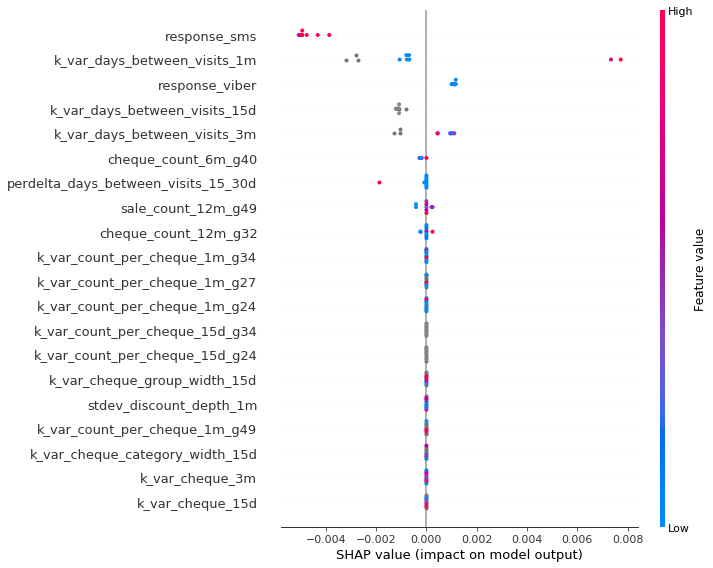

In [41]:
shap.summary_plot(shap_values, test[:10])

In [14]:
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
data.fillna(0., inplace=True)
model1 = xgboost.XGBClassifier(n_estimators=2, random_seed=42)
model2 = LogisticRegression()
model3 = xgboost.XGBClassifier(n_estimators=2, random_seed=43)
model = StackedModel([model1, model2, model3])

In [15]:
res = validate_on_holdout(data, model, verbose=True)

XGBClassifier(n_esti
Точность: 0.6709095672678049
 ROC AUC: 0.6604728119096358
LogisticRegression()
Точность: 0.6672343274675051
 ROC AUC: 0.6075199841514369
XGBClassifier(n_esti
Точность: 0.6709095672678049
 ROC AUC: 0.6604728119096358


In [16]:
res[0]

{'train': 4.306977339431651,
 'test': 3.7853080897582463,
 'train_random': 0.927765969366139,
 'test_random': 0.8470984773112479}

In [58]:
a = np.array(res[-3]).reshape(-1, 3)

In [22]:
import sys
sys.path.append('../scripts')
import numpy as np
import modin.pandas as pd

from importlib import reload
import pipeline
reload(pipeline)
from pipeline import validate_on_holdout, IndianModel, StackedModel, SemiStackedModel, BlendedModel
pd.options.mode.chained_assignment = None

In [8]:
import xgboost

In [19]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators': 1, 'eval_metric': ['merror', 'mlogloss'], 'verbose': True, 'n_jobs': -1,
         'random_state':42}
model1 = xgboost.XGBClassifier(**params)
model2 = LogisticRegression(random_state=42)
model3 = RandomForestClassifier(n_jobs=-1, n_estimators=10)
top_model = xgboost.XGBClassifier(**params)
model = SemiStackedModel({'xgboost': model1, 'logistic': model2, 'random forest': model3}, top_model)

In [25]:
params = {'n_estimators': 10, 'n_jobs': -1,
         'subsample': 0.3, 'colsample_bytree': 0.3}

models = {}
for i in range(1, 11):
    models[str(i)] = xgboost.XGBClassifier(**params, random_state=i)

model = BlendedModel(models)

In [26]:
res = validate_on_holdout(data, model, verbose=True)
res[0]


1
Точность: 0.6705820706519366
ROC AUC: 0.6819099777777304

2
Точность: 0.670465627410739
ROC AUC: 0.6808351535840116

3
Точность: 0.6706694030828348
ROC AUC: 0.6804836845482883

4
Точность: 0.6701963524154695
ROC AUC: 0.6800605924964285

5
Точность: 0.6709968996987031
ROC AUC: 0.6809605418915791

6
Точность: 0.6706548476776851
ROC AUC: 0.6818352316142008

7
Точность: 0.6704510720055893
ROC AUC: 0.6827901114698242

8
Точность: 0.670611181462236
ROC AUC: 0.6795117471950265

9
Точность: 0.670218185523194
ROC AUC: 0.6820886290794892

10
Точность: 0.6706257368673857
ROC AUC: 0.6804808700654165

Модель верхнего уровня 
ROC AUC: 0.6832934540901223


{'train': 5.93699594124886, 'test': 6.155531888040403}

In [57]:
model = res[1]

In [58]:
test = res[-1].drop(['group', 'response_att', 'uplift'], axis=1)

In [60]:
preds = model.models['xgboost'].predict_proba(test.values)

In [61]:
final = preds[:, 3] + preds[:, 0] - preds[:, 1] - preds[:, 2]

In [64]:
from metrics import custom_metric
res[-1]['uplift'] = final

custom_metric(res[-1])

5.785339671041393

In [7]:
data['gender'].replace({'Ж': 0, 'М': 1, 'Не определен': np.NaN}, inplace=True)
data.fillna(0., inplace=True)

In [20]:
params = {'n_estimators': 3, 'eval_metric': ['merror', 'mlogloss'], 'verbose': True, 'n_jobs': -1}
model = IndianModel(params)

res = validate_on_holdout(data, model, verbose=True)
res[0]

[0]	validation_0-merror:0.329127	validation_0-mlogloss:1.31563
[1]	validation_0-merror:0.329163	validation_0-mlogloss:1.25668
[2]	validation_0-merror:0.329105	validation_0-mlogloss:1.20595


{'train': 6.228393892661374,
 'test': 5.3650512950905425,
 'train_random': 0.6298483926953268,
 'test_random': 0.6159768527838676}

In [23]:
test = res[-1].drop(['group', 'response_att', 'uplift'], axis=1)

In [24]:
import shap
# load JS visualization code to notebook
shap.initjs()


# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.KernelExplainer(model.predict, test[:100].values)
shap_values = explainer.shap_values(test[:10].values)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [25]:
import shap
shap.force_plot(explainer.expected_value, shap_values[2], test.iloc[0])